In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re
import pickle
import seaborn as sns
import os

# Exploração do dados

In [3]:
# Carregar o conjunto de dados
df = pd.read_csv("news.csv")

In [4]:
# Exibir as primeiras linhas do DataFrame
print("Primeiras linhas do DataFrame:")
df.head()

Primeiras linhas do DataFrame:


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [5]:
# Dropando coluna inútil
df = df.drop('Unnamed: 0', axis=1)

In [6]:
# Verificando quantidade de linhas e colunas
df.shape


(6335, 3)

In [7]:
# Verificar os tipos de dados das colunas
print("\nTipos de dados das colunas:")
df.dtypes


Tipos de dados das colunas:


title    object
text     object
label    object
dtype: object

In [8]:
# Contagem de valores para a coluna de rótulos
print("\nContagem de valores para a coluna de rótulos:")
print(df['label'].value_counts())


Contagem de valores para a coluna de rótulos:
label
REAL    3171
FAKE    3164
Name: count, dtype: int64


In [9]:
# 0 valores faltantes
print("\nContagem de valores faltantes:")
df.isnull().sum()


Contagem de valores faltantes:


title    0
text     0
label    0
dtype: int64

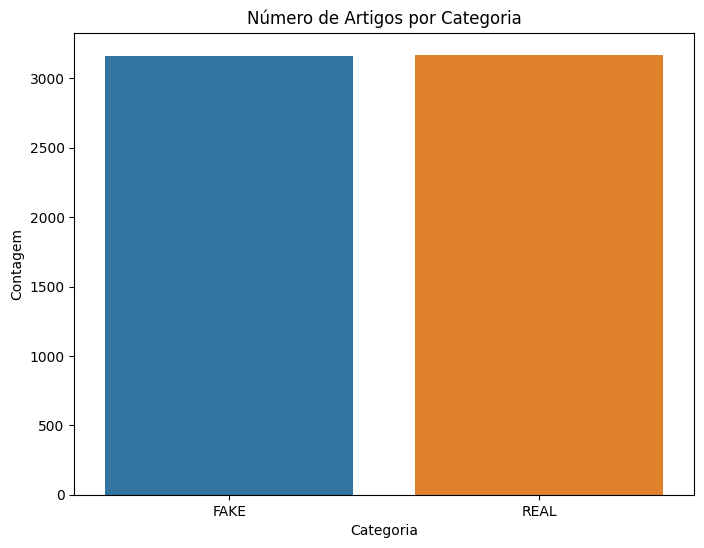

In [10]:
# Análise dos dados
# Número de artigos por categoria
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.xlabel('Categoria')
plt.ylabel('Contagem')
plt.title('Número de Artigos por Categoria')
plt.show()

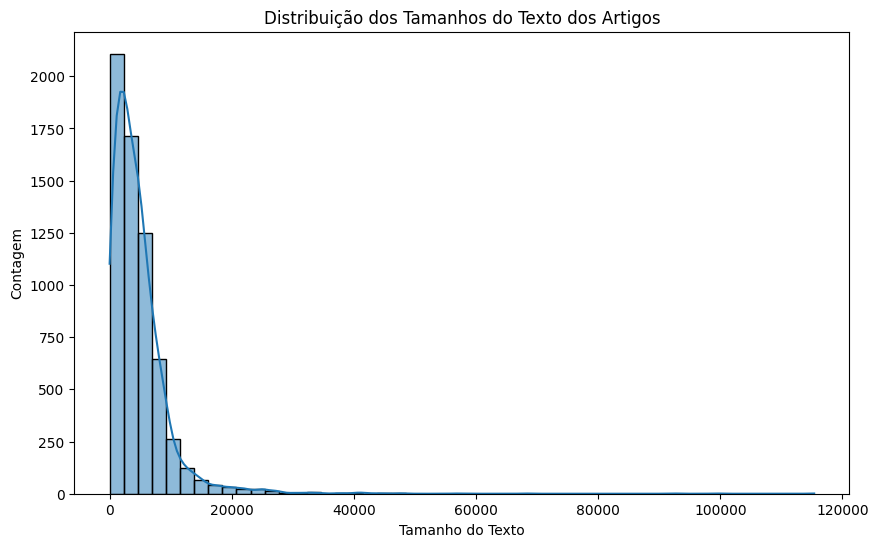

In [11]:
# Distribuição dos tamanhos do texto dos artigos
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.xlabel('Tamanho do Texto')
plt.ylabel('Contagem')
plt.title('Distribuição dos Tamanhos do Texto dos Artigos')
plt.show()

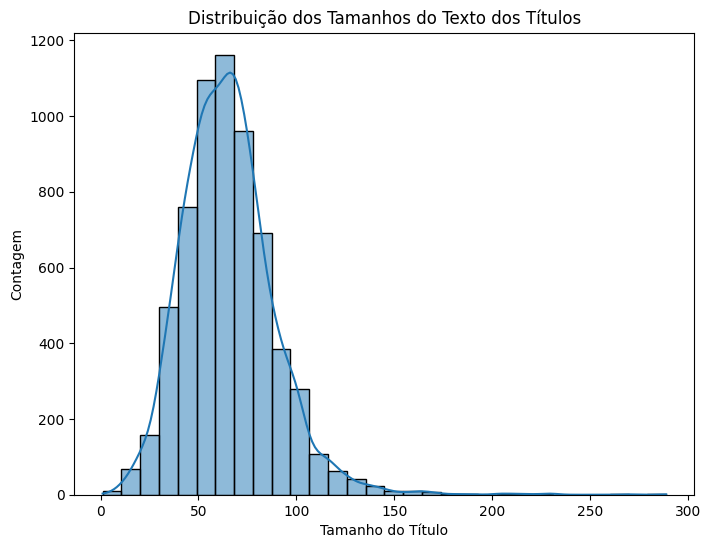

In [12]:
# Distribuição dos tamanhos do texto dos títulos
df['title_length'] = df['title'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df['title_length'], bins=30, kde=True)
plt.xlabel('Tamanho do Título')
plt.ylabel('Contagem')
plt.title('Distribuição dos Tamanhos do Texto dos Títulos')
plt.show()

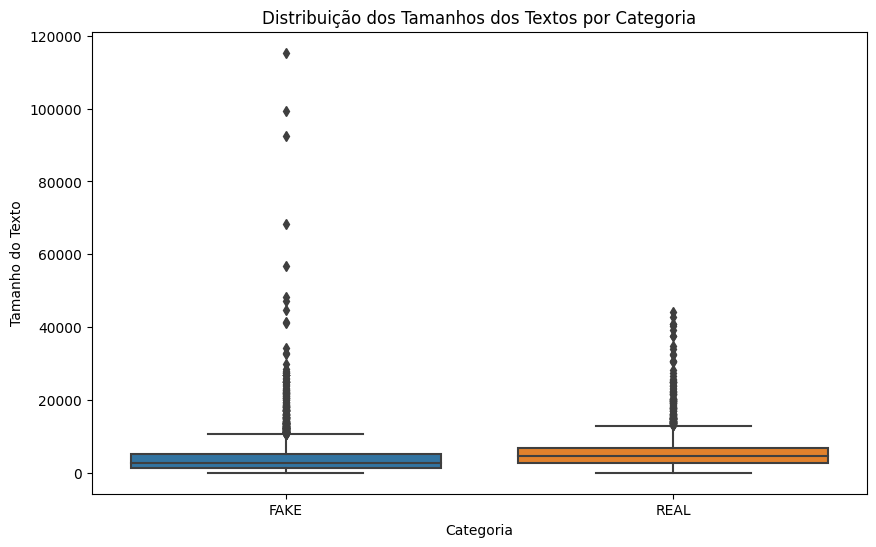

In [13]:
# histograma com densidade para exibir a distribuição dos tamanhos dos títulos nos artigos.
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='text_length', data=df)
plt.xlabel('Categoria')
plt.ylabel('Tamanho do Texto')
plt.title('Distribuição dos Tamanhos dos Textos por Categoria')
plt.show()

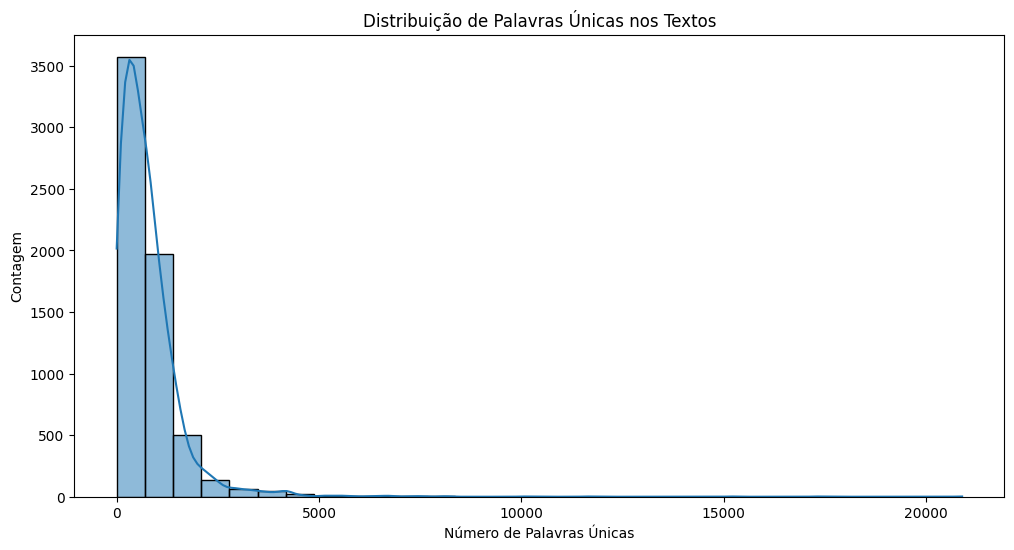

In [14]:
# gráfico que mostra a distribuição dos tamanhos dos textos nos artigos para cada categoria presente no conjunto de dados.
word_counts = df['text'].str.split().apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(word_counts, bins=30, kde=True)
plt.xlabel('Número de Palavras Únicas')
plt.ylabel('Contagem')
plt.title('Distribuição de Palavras Únicas nos Textos')
plt.show()

# Pré Processamento

In [15]:
# Codificando as categorias
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [16]:
# Baixando recursos do NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# Função de pré-processamento com o NLTK
def preprocess_text(text):
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]
    text = ' '.join(tokens)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()
    return text

In [18]:
# Aplicando pré-processamento à coluna de texto
df['text'] = df['text'].apply(preprocess_text)

In [19]:
# Dividindo o conjunto de dados em treino, teste e validação
train_data, test_data, train_labels, test_labels = train_test_split(df[['text', 'title']], df['label'], test_size=0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [20]:
# Pré-processando os títulos e combinando com o texto
train_data['title'] = train_data['title'].apply(preprocess_text)
train_data['combined'] = train_data['text'] + ' ' + train_data['title']
test_data['title'] = test_data['title'].apply(preprocess_text)
test_data['combined'] = test_data['text'] + ' ' + test_data['title']
val_data['title'] = val_data['title'].apply(preprocess_text)
val_data['combined'] = val_data['text'] + ' ' + val_data['title']

In [21]:
# Vetorizer usando TF-IDF
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['combined'])
X_test = vectorizer.transform(test_data['combined'])
X_val = vectorizer.transform(val_data['combined'])
y_train = train_labels
y_test = test_labels
y_val = val_labels

# Treinamento

In [22]:
# Definindo os modelos a serem testados 
models = [
    RandomForestClassifier(),
    SVC(),
    LogisticRegression(),
    MLPClassifier()
]

In [23]:
# Definindo os parâmetros para busca em grade para o RandomForestClassifier
parameters = [
    {'n_estimators': [50, 100, 150, 200, 250], 'max_depth': [None, 5, 10, 15, 20]},
    {'C': [0.1, 1, 10]},  # Regularização C para SVC
    {},  # Nenhum parâmetro necessário para LogisticRegression
    {'hidden_layer_sizes': [(100,), (100, 100)], 'alpha': [0.0001, 0.001]}  # Parâmetros da rede neural
]

In [24]:
best_models = []


In [25]:
# Treinando e avaliando os modelos
for model, params in zip(models, parameters):
    grid_search = GridSearchCV(model, params, cv=5)  
    grid_search.fit(X_train, train_labels)
    best_model = grid_search.best_estimator_
    best_models.append(best_model)
    y_test_pred = best_model.predict(X_test)
    accuracy = accuracy_score(test_labels, y_test_pred)

    print(f"Modelo: {type(model).__name__}")
    print(f"Melhores parâmetros: {grid_search.best_params_}")
    print(f"Acurácia no Teste: {accuracy}")
    print(f"Melhor pontuação cross-validada: {grid_search.best_score_}\n")

Modelo: RandomForestClassifier
Melhores parâmetros: {'max_depth': None, 'n_estimators': 150}
Acurácia no Teste: 0.9060773480662984
Melhor pontuação cross-validada: 0.8988683381285109

Modelo: SVC
Melhores parâmetros: {'C': 10}
Acurácia no Teste: 0.9392265193370166
Melhor pontuação cross-validada: 0.9287123045774918

Modelo: LogisticRegression
Melhores parâmetros: {}
Acurácia no Teste: 0.9171270718232044
Melhor pontuação cross-validada: 0.9079925712806929

Modelo: MLPClassifier
Melhores parâmetros: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 100)}
Acurácia no Teste: 0.9447513812154696
Melhor pontuação cross-validada: 0.9356204046216376



In [26]:
# Selecionando o melhor modelo
best_model = max(best_models, key=lambda m: accuracy_score(test_labels, m.predict(X_test)))

In [27]:
# Treinando o melhor modelo com o conjunto de dados completo
best_model.fit(X_train, train_labels)

MLPClassifier(hidden_layer_sizes=(100, 100))

In [28]:
MLPClassifier(alpha=0.001)


MLPClassifier(alpha=0.001)

In [29]:
# Avaliando o melhor modelo no conjunto de validação
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(val_labels, y_val_pred)
print(f"Acurácia do Melhor Modelo na Validação: {val_accuracy}")

Acurácia do Melhor Modelo na Validação: 0.9319526627218935


In [30]:
# Criando uma matriz de confusão
conf_matrix = confusion_matrix(test_labels, y_test_pred)

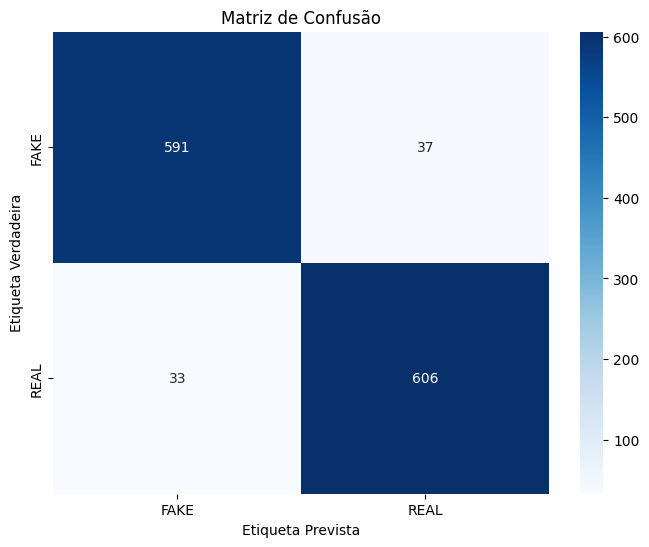

In [31]:
# Plotando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Etiqueta Prevista')
plt.ylabel('Etiqueta Verdadeira')
plt.title('Matriz de Confusão')
plt.show()

In [32]:
# Salvando o melhor modelo em um arquivo usando pickle
model_filename = 'best_model.pkl'
model_folder = 'C:\\Users\\gabri\\OneDrive\\Área de Trabalho\\projeto-final'

In [33]:
model_path = os.path.join(model_folder, model_filename)

In [34]:
# Salvando o melhor modelo em um arquivo usando pickle
with open(model_path, 'wb') as file:
    pickle.dump(best_model, file)

print(f"O melhor modelo MLPClassifier foi salvo em: {model_path}")

O melhor modelo MLPClassifier foi salvo em: C:\Users\gabri\OneDrive\Área de Trabalho\projeto-final\best_model.pkl


In [35]:
# Salvando o melhor vetorizer em um arquivo usando pickle
vectorizer_filename = 'best_vectorizer.pkl'
vectorizer_path = os.path.join(model_folder, vectorizer_filename)

with open(vectorizer_path, 'wb') as file:
    pickle.dump(vectorizer, file)

print(f"O melhor vetorizer foi salvo em: {vectorizer_path}")

O melhor vetorizer foi salvo em: C:\Users\gabri\OneDrive\Área de Trabalho\projeto-final\best_vectorizer.pkl
